# Introduction to Predictive Maintenance using Deep Learning
## Fault Classification using deep learning with Keras

#### Author Nagdev Amruthnath
Date: 1/10/2019

##### Citation Info
If you are using this for your research, please use the following for citation. 

Amruthnath, Nagdev, and Tarun Gupta. "A research study on unsupervised machine learning algorithms for early fault detection in predictive maintenance." In 2018 5th International Conference on Industrial Engineering and Applications (ICIEA), pp. 355-361. IEEE, 2018.

##### Disclaimer
This is a tutorial for performing fault detection using machine learning. You this code at your own risk. I do not gurantee that this would work as shown below. If you have any suggestions please branch this project.

## Introduction
This is the first of four part demostration series of using machine learning for predictive maintenance.   

The area of predictive maintenance has taken a lot of prominence in the last couple of years due to various reasons. With new algorithms and methodologies growing across different learning methods, it has remained a challenge for industries to adopt which method is fit, robust and provide most accurate detection. One the most common learning approaches used today for fault diagnosis is supervised learning. This is wholly based on the predictor variable and response variable. In this tutorial, we will be looking into deep learning models for fault classification using keras package in R.


## Load libraries 

In [1]:
options(warn=-1)
#install.packages("keras")
# load libraries
library(keras)
library(caret)
library(dplyr)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# install keras
install_keras()

Using virtual environment '~/.virtualenvs/r-reticulate' ...

Installation complete.



## Load data
Here we are using data from a bench press. There are total of four different states in this machine and they are split into four different csv files. We need to load the data first. In the data time represents the time between samples, ax is the acceleration on x axis, ay is the acceleration on y axis, az is the acceleration on z axis and at is the G's. The data was collected at sample rate of 100hz.   

Four different states of the machine were collected  
1. Nothing attached to drill press
2. Wooden base attached to drill press
3. Imbalance created by adding weight to one end of wooden base
4. Imbalacne created by adding weight to two ends of wooden base.

In [3]:
setwd("/home")
#read csv files
file1 = read.csv("dry run.csv", sep=",", header =T)
file2 = read.csv("base.csv", sep=",", header =T)
file3 = read.csv("imbalance 1.csv", sep=",", header =T)
file4 = read.csv("imbalance 2.csv", sep=",", header =T)

#Add labels to data
file1$y = 1
file2$y = 2
file3$y = 3
file4$y = 4

#view top rows of data
head(file1)

time,ax,ay,az,aT,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.002,-0.3246,0.2748,0.1502,0.451,1
0.009,0.6020,-0.1900,-0.3227,0.709,1
0.019,0.9787,0.3258,0.0124,1.032,1
0.027,0.6141,-0.4179,0.0471,0.744,1
0.038,-0.3218,-0.6389,-0.4259,0.833,1
0.047,-0.3607,0.1332,-0.1291,0.406,1


We can look at the summary of each file using summary function in R. Below, we can observe that 66 seconds long data is available. We also have min, max and mean for each of the variables. 

In [4]:
# summary of each file
summary(file1)

      time              ax                 ay                  az         
 Min.   : 0.002   Min.   :-2.11880   Min.   :-2.143600   Min.   :-4.1744  
 1st Qu.:16.507   1st Qu.:-0.41478   1st Qu.:-0.625250   1st Qu.:-0.7359  
 Median :33.044   Median : 0.02960   Median :-0.022050   Median :-0.1468  
 Mean   :33.037   Mean   : 0.01233   Mean   : 0.008697   Mean   :-0.1021  
 3rd Qu.:49.535   3rd Qu.: 0.46003   3rd Qu.: 0.641700   3rd Qu.: 0.4298  
 Max.   :66.033   Max.   : 2.09620   Max.   : 2.003000   Max.   : 4.9466  
       aT              y    
 Min.   :0.032   Min.   :1  
 1st Qu.:0.848   1st Qu.:1  
 Median :1.169   Median :1  
 Mean   :1.277   Mean   :1  
 3rd Qu.:1.579   3rd Qu.:1  
 Max.   :5.013   Max.   :1  

## Data Aggregration and feature extraction
Here, the data is aggregated by 1 minute and features are extracted. Features are extracted to reduce the dimension of the data and only storing the representation of the data. 

In [5]:
file1$group = as.factor(round(file1$time))
file2$group = as.factor(round(file2$time))
file3$group = as.factor(round(file3$time))
file4$group = as.factor(round(file4$time))
#(file1,20)

#list of all files
files = list(file1, file2, file3, file4)

#loop through all files and combine
features = NULL
for (i in 1:4){
res = files[[i]] %>%
    group_by(group) %>%
    summarize(ax_mean = mean(ax),
              ax_sd = sd(ax),
              ax_min = min(ax),
              ax_max = max(ax),
              ax_median = median(ax),
              ay_mean = mean(ay),
              ay_sd = sd(ay),
              ay_min = min(ay),
              ay_may = max(ay),
              ay_median = median(ay),
              az_mean = mean(az),
              az_sd = sd(az),
              az_min = min(az),
              az_maz = max(az),
              az_median = median(az),
              aT_mean = mean(aT),
              aT_sd = sd(aT),
              aT_min = min(aT),
              aT_maT = max(aT),
              aT_median = median(aT),
              y = mean(y)
             )
    features = rbind(features, res)
}

#view all features
features$y = as.factor(features$y)
head(features)

group,ax_mean,ax_sd,ax_min,ax_max,ax_median,ay_mean,ay_sd,ay_min,ay_may,⋯,az_sd,az_min,az_maz,az_median,aT_mean,aT_sd,aT_min,aT_maT,aT_median,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,-0.038164706,0.6594686,-1.2587,1.3821,-0.0955,-0.0682627451,0.7506785,-1.3892,1.6418,⋯,0.9845115,-2.6753,2.7507,0.0254,1.273216,0.5830149,0.400,3.029,1.0770,1
1,-0.005806122,0.6325808,-1.6194,1.1943,-0.0015,0.0037908163,0.7819044,-1.5625,1.5428,⋯,0.9252188,-3.0774,2.7158,-0.2121,1.263622,0.5448447,0.410,3.197,1.1375,1
2,0.069845455,0.6665500,-1.4554,1.4667,0.1070,0.0744333333,0.8022922,-1.4800,1.7951,⋯,0.9293866,-1.8205,2.4862,-0.1512,1.298364,0.5131552,0.255,2.644,1.2830,1
3,0.011552525,0.5511310,-1.9254,1.2034,0.0675,0.0008262626,0.7894209,-2.0042,1.5577,⋯,0.8893505,-2.1562,3.2355,-0.1672,1.203848,0.5125826,0.393,3.322,1.1180,1
4,0.046688119,0.6426574,-1.7805,1.4837,0.0836,-0.0177594059,0.7510811,-1.6629,1.4369,⋯,0.9265720,-1.8515,3.5451,-0.1741,1.226267,0.5824608,0.313,3.597,1.1720,1
5,0.006678788,0.5780957,-1.4719,1.4355,0.0536,0.0013626263,0.7812245,-1.6293,1.6362,⋯,0.9091516,-2.5561,2.9196,-0.2588,1.209515,0.5664847,0.336,3.035,1.1590,1


## Create sample size for training the model
From the information, we know that we have four states in the data. Based on this information, the data is split into train and test samples. The train set is used to build the model and test set is used to validate the model. The ratio between train and test is 80:20. You can adjust this based on type of data. The below table shows the number of observations for each group.   

Note: It is adviced to have atleast 30 samples for each group. 

In [6]:
table(features$y)



  1   2   3   4 
 67 109  93  93 

From the above results, we can observe that there are atleast 30 samples for each group. Now, we can used this data to split into train and test set. 

In [7]:
#create samples of 80:20 ratio
sample = sample(nrow(features) , nrow(features)* 0.8)
train = features[sample,2:21]
test = features[-sample,2:21]

## Deep Learning

### Fault Classification using Keras
TensorFlow™ is an open-source software library for Machine Intelligence. The R interface to TensorFlow lets you work productively using the high-level Keras and Estimator APIs, and when you need more control provides full access to the core TensorFlow API

The Keras API for TensorFlow provides a high-level interface for neural networks, with a focus on enabling fast experimentation  

The Estimator API for TensorFlow provides high-level implementations of common model types such as regressors and classifiers.  

The Core TensorFlow API is a lower-level interface that provides full access to the TensorFlow computational graph.

#### One-hot encoding on labels
The labels on the data needs to be one-hot encoded for a keras model to be trained. There are a lot of advantages of doing so in training and you can read about it. Here, for one-hot encoding, we will be using caret package and dummy function as shown below. Then we will spit the labels as per train and test. 


In [8]:
# perform one-hot encoding
dmy = dummyVars(" ~ y", data = features)
onehot = data.frame(predict(dmy, newdata = features))

# view the top data
head(onehot)

# split the labels
trainY = onehot[sample,]
testY = onehot[-sample,]

y.1,y.2,y.3,y.4
<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0


In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the sequential model.  
There are few things to notice here:    
  - Layer dense is the densly connected neural network later  
  - Unit is the neurons in the neural network  
  - input_shape is the number of predictors  
  - Layer_dropout applies Dropout to the input.  

In [9]:
## create your model,and add layers 
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 60, activation = 'relu', input_shape = ncol(train)) %>% 
  layer_dropout(rate = 0.2) %>% 
  layer_dense(units = 50, activation = 'relu') %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 4, activation = 'softmax')

## see your model structure
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 60)                      1260        
________________________________________________________________________________
dropout (Dropout)                   (None, 60)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 50)                      3050        
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 50)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 4)                       204         
Total params: 4,514
Trainable params: 4,514
Non-trainable params: 0
_____________________

compile function configures a Keras model for training. Here we, load what model to use, type of loss, metrics and optimizers. 

In [10]:
compile(model, loss = "categorical_crossentropy", optimizer = optimizer_adam( lr= 0.0001 , decay = 1e-6 ), metrics = "accuracy")

Finally, the model can be trained with different epochs, batches and split size. From the trained model we can notice that trained accuracy validation accuracy.

Trained on 231 samples (batch_size=32, epochs=2,000)
Final epoch (plot to see history):
        loss: 0.1193
    accuracy: 0.9567
    val_loss: 0.2106
val_accuracy: 0.931 

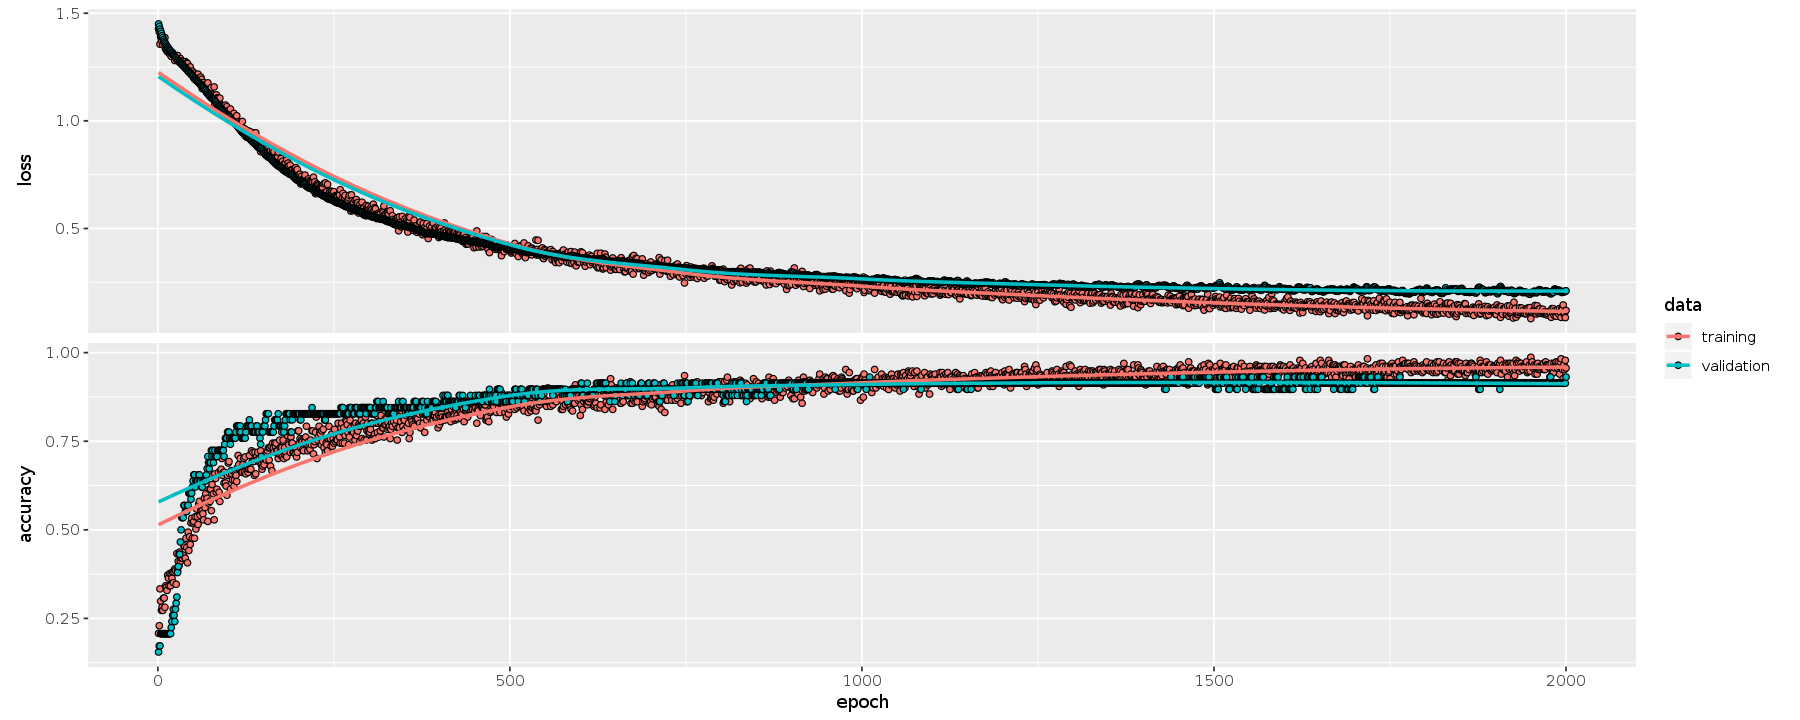

In [11]:
# train the model
history = fit(model,  data.matrix(train), data.matrix(trainY), epochs = 2000, batch_size = 32, validation_split = 0.2)

# show trained information
history

# Adjust plot sizes
options(repr.plot.width = 15, repr.plot.height = 6)
plot(history)


Finally, we can evaluate the model with the test data. The loss and test accuracies can be as seen below. Neural networks using keras package is one of the methods that we can use to train our fault classification mdoels. 

In [12]:
model %>% evaluate(data.matrix(test), data.matrix(testY), batch_size = 8)

$loss
[1] 0.1210483

$accuracy
[1] 0.9452055

#### References

[1] Amruthnath, Nagdev, and Tarun Gupta. "A research study on unsupervised machine learning algorithms for early fault detection in predictive maintenance." In 2018 5th International Conference on Industrial Engineering and Applications (ICIEA), pp. 355-361. IEEE, 2018.

[2] Amruthnath, Nagdev, and Tarun Gupta. "Fault class prediction in unsupervised learning using model-based clustering approach." In Information and Computer Technologies (ICICT), 2018 International Conference on, pp. 5-12. IEEE, 2018.

[3] https://tensorflow.rstudio.com

[4] https://amunategui.github.io/dummyVar-Walkthrough/